In [1]:
import matplotlib.pyplot as plt
import math
import torch
import V1_DAE as V1
import NR
import importlib
import FitzNag as FN
import DAE_solver as DS
from data_generator import *
import torchvision
import torchvision.datasets as datasets

In [2]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.cuda.set_device(0) #use GPU 1

In [3]:
#Load MNIST
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
data_load = torch.utils.data.DataLoader(mnist_trainset, shuffle = True)

In [4]:
mov_len = 5
images = data_load.dataset.data[0:1000].numpy()
M = rand_trans(images, 1, 3)
data_mov = torch.from_numpy(image_gen(images,M, mov_len)).float().cuda()
data_mov = data_mov/255

In [5]:
importlib.reload(V1)

<module 'V1_DAE' from '/home/shazoop/form-and-motion/EE219A/V1_DAE.py'>

In [6]:
main = V1.fullV1()

In [7]:
main.summary()

['In the hidden layer, there are 25 units per slice, with depth 16, and RF size: 12 by 12',
 'In the top layer, there are 16 units',
 'There are 400 hidden units, 16 top units, and 1248 units in total.',
 'Fitz-Nag parameters (a,b, tau) are (0.7,0.8, 12.5).',
 'Self-activation parameter is 0.5']

In [8]:
x, funargs= main.init()

In [9]:
Input = torch.rand(28,28)

In [12]:
#Test run. SInce linear, should converge in 1 step for NR.
f = lambda x ,funargs: torch.tensor([[3,0],[0,1]]).float() @ x
df = lambda x, funargs: torch.tensor([[3,0],[0,1]]).float()
xinit = torch.tensor([0,0]).float()
NR.NR(f,df,xinit, [])

(tensor([0., 0.]), 1, 1)

In [310]:
importlib.reload(FN)
importlib.reload(DS)

<module 'DAE_solver' from '/home/shazoop/form-and-motion/EE219A/DAE_solver.py'>

In [13]:
fitz = FN.FN(n = 1, tau = 10)
x = fitz.init()

In [14]:
#x = torch.tensor([1,-1]).float().cuda()

In [15]:
u = .12*torch.ones(1)

In [16]:
DSsolve = DS.DAE_solver(fitz,x,u, funargs = [], h = .25, tstop = 10, method = 'Trap')

In [17]:
tpts, xpts = DSsolve.solve()

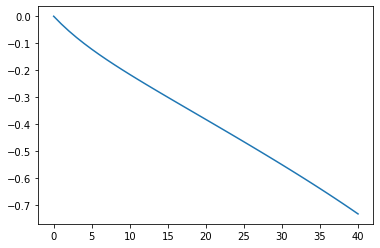

In [18]:
plt.plot(xpts[:,0].cpu().numpy())

In [19]:
importlib.reload(V1)
importlib.reload(DS)

<module 'DAE_solver' from '/home/shazoop/form-and-motion/EE219A/DAE_solver.py'>

In [20]:
main = V1.fullV1(tau = 10, lam = 0)

In [21]:
main.summary()

['In the hidden layer, there are 25 units per slice, with depth 16, and RF size: 12 by 12',
 'In the top layer, there are 16 units',
 'There are 400 hidden units, 16 top units, and 1248 units in total.',
 'Fitz-Nag parameters (a,b, tau) are (0.7,0.8, 10).',
 'Self-activation parameter is 0']

In [22]:
x, funargs = main.init()

In [23]:
data_mov[0,0].shape

torch.Size([28, 28])

In [24]:
u = .2*main.uMul(data_mov[0,0],funargs)

In [27]:
DSsolve = DS.DAE_solver(main,x,u, funargs = funargs, h = .1, tstop = 10, method = 'Trap', \
                        NRparms = {'maxiter': 100, 'reltol': 1e-6, 'abstol': 1e-6, 'restol': 1e-9, 'convcrit': 'dxORres' })

In [28]:
_, xpts = DSsolve.solve()


NR failed to solve nonlinear equations - reached maxiter=100
NR failed to converge at time 1.0999999999999999, step 11


In [29]:
torch.argmax(xpts[50])

IndexError: index 50 is out of bounds for dimension 0 with size 13

In [418]:
A = torch.rand(3)
B = torch.rand_like(A)

In [419]:
A/B

tensor([1.3254, 1.2865, 0.4113])

In [420]:
A[0]/B[0]

tensor(1.3254)

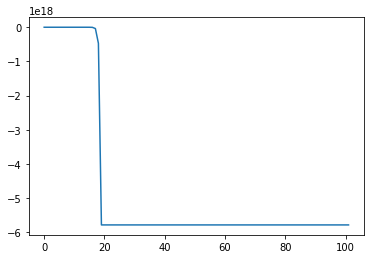

In [416]:
ix = 1217
plt.plot(xpts[:,0].cpu().numpy())

In [ ]:
for train in trainSteps:
    input_mov = data_mov[int(np.random.randint(0,data_mov.size(0),1))] #select a random movie sequence
    x = main.xinit()
    for i in range(mov_len):
        
        


In [ ]:
torch.cat((torch.cat((a,b), dim = 0),c), dim = 0)

In [ ]:
C  = torch.stack((a,b))

In [ ]:
a